# Experiment 3
This is the third experiment for the paper entitled "DAE: Towards Enpowering Denoising in Side-Channel Analysis".

The ASCAD dataset can be downloaded from https://github.com/ANSSI-FR/ASCAD.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import sys
import h5py
import numpy as np
from keras.layers import *
from keras.models import Model,Sequential
from keras import backend as K
import scipy.io as scio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras import regularizers
from keras import losses
import sklearn.preprocessing

import os
from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

## adjust this according to your configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))


from utils import snr,corr,cal_HMweight

AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B,
    0xFE, 0xD7, 0xAB, 0x76, 0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0,
    0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0, 0xB7, 0xFD, 0x93, 0x26,
    0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2,
    0xEB, 0x27, 0xB2, 0x75, 0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0,
    0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84, 0x53, 0xD1, 0x00, 0xED,
    0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F,
    0x50, 0x3C, 0x9F, 0xA8, 0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5,
    0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2, 0xCD, 0x0C, 0x13, 0xEC,
    0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14,
    0xDE, 0x5E, 0x0B, 0xDB, 0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C,
    0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79, 0xE7, 0xC8, 0x37, 0x6D,
    0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F,
    0x4B, 0xBD, 0x8B, 0x8A, 0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E,
    0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E, 0xE1, 0xF8, 0x98, 0x11,
    0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F,
    0xB0, 0x54, 0xBB, 0x16
])

experiment_id = '3'


# Extract Traces

50000 traces for profiling, 10000 traces for attack.

In [2]:
# load data
ascad_data_folder = "./ASCAD/ASCAD_data/"
ascad_databases_folder = ascad_data_folder + "ASCAD_databases/"
in_file  = h5py.File(ascad_databases_folder+ "ASCAD.h5", "r")
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
Y_profiling = np.array(in_file['Profiling_traces/labels'])
X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
Y_attack = np.array(in_file['Attack_traces/labels'])
m1,m2 = in_file['Profiling_traces/metadata'], np.array(in_file['Attack_traces/metadata'])

# 688/16 =42 for the convenience of downsampling and upsampling in conv_skip_dae, clip 12 points
X_profiling = X_profiling[:,:-12]
X_attack = X_attack[:,:-12]

v1 = AES_Sbox[m1['plaintext'][:,2] ^ m1['key'][:,2]]
v2 = v1 ^ m1['masks'][:,15]
v3 = m1['masks'][:,15]
v4 = v1 ^ m1['masks'][:,0]
v5 = m1['masks'][:,0]

# generate noisy-clean training pair
v4_profiling,v5_profiling = v4,v5
v4_attack,v5_attack = AES_Sbox[m2['plaintext'][:,2] ^ m2['key'][:,2]] ^ m2['masks'][:,0], m2['masks'][:,0]

cut_length = int(X_profiling.shape[1]/2)

X_profiling_maskSout_mean = np.zeros((256,cut_length))
X_profiling_mask_mean = np.zeros((256,cut_length))
for i in range(256):
    X_profiling_maskSout_mean[i] = (np.mean(X_profiling[np.where(v4_profiling==i)[0],cut_length:],axis=0))
    X_profiling_mask_mean[i] = (np.mean(X_profiling[np.where(v5_profiling==i)[0],:cut_length],axis=0))
    
X_profiling_clean = np.zeros(X_profiling.shape)
X_attack_clean = np.zeros(X_attack.shape)
for i in range(len(X_profiling)):
    X_profiling_clean[i,:] = np.hstack((X_profiling_mask_mean[v5_profiling[i],:],X_profiling_maskSout_mean[v4_profiling[i],:]))
for i in range(len(X_attack)):
    X_attack_clean[i,:] = np.hstack((X_profiling_mask_mean[v5_attack[i],:],X_profiling_maskSout_mean[v4_attack[i],:]))

## Trace Scaling

In [11]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_profiling = min_max_scaler.fit_transform(X_profiling)
X_attack = min_max_scaler.transform(X_attack)

## Build CDAE and Train

In [8]:
def conv_skip_dae(loss='mse',
                  optimizer='adam',
                  MultiGPU=False):

    input_dim = X_profiling.shape[1]
    # this is our input placeholder
    input_img = Input(shape=(input_dim, 1))


    encoded1 = Conv1D(16, 3, padding='same', name='Conv1')(input_img)

    encoded1 = LeakyReLU(alpha=0.2)(encoded1)
    encoded1 = BatchNormalization(momentum=0.8)(encoded1)
    encoded1 = MaxPooling1D(2, padding='same', name='DownSampling1')(encoded1)
    
    encoded2 = Conv1D(32, 3, padding='same', name='Conv2')(encoded1)
    encoded2 = LeakyReLU(alpha=0.2)(encoded2)
    encoded2 = BatchNormalization(momentum=0.8)(encoded2)
    encoded2 = MaxPooling1D(2, padding='same', name='DownSampling2')(encoded2)
    
    encoded3 = Conv1D(64, 3, padding='same', name='Conv3')(encoded2)
    encoded3 = LeakyReLU(alpha=0.2)(encoded3)
    encoded3 = BatchNormalization(momentum=0.8)(encoded3)
    encoded3 = MaxPooling1D(2, padding='same', name='DownSampling3')(encoded3)
    
    encoded4 = Conv1D(128, 3, padding='same', name='Conv4')(encoded3)
    encoded4 = LeakyReLU(alpha=0.2)(encoded4)
    encoded4 = BatchNormalization(momentum=0.8)(encoded4)
    encoder_output = MaxPooling1D(2, padding='same', name='Encoded')(encoded4)

    # decoder
    decoded5 = Conv1D(128, 3, padding='same', name='Conv5')(encoder_output)
    decoded5 = LeakyReLU(alpha=0.2)(decoded5)
    decoded5 = BatchNormalization(momentum=0.8)(decoded5)
    
    decoded5 = add([decoded5, encoder_output])
    
    decoded6 = UpSampling1D(2, name='UpSampling5')(decoded5)
    decoded6 = Conv1D(64, 3, padding='same', name='Conv6')(decoded6)
    decoded6 = LeakyReLU(alpha=0.2)(decoded6)
    decoded6 = BatchNormalization(momentum=0.8)(decoded6)

    decoded6 = add([decoded6, encoded3])
    
    decoded7 = UpSampling1D(2, name='UpSampling6')(decoded6)
    decoded7 = Conv1D(32, 3, padding='same', name='Conv7')(decoded7)
    decoded7 = LeakyReLU(alpha=0.2)(decoded7)
    decoded7 = BatchNormalization(momentum=0.8)(decoded7)

    decoded7 = add([decoded7, encoded2])
    
    decoded8 = UpSampling1D(2, name='UpSampling7')(decoded7)
    decoded8 = Conv1D(16, 3, padding='same', name='Conv8')(decoded8)
    decoded8 = LeakyReLU(alpha=0.2)(decoded8)
    decoded8 = BatchNormalization(momentum=0.8)(decoded8)
    
    decoded8 = add([decoded8, encoded1])
    
    decoded9 = UpSampling1D(2, name='UpSampling8')(decoded8)
    decoded9 = Conv1D(1, 3, activation='tanh', padding='same',
                      name='Conv9')(decoded9)

    encoder = Model(inputs=input_img, outputs=encoder_output)

    autoencoder = Model(inputs=input_img, outputs=decoded9)
    print(autoencoder.summary())

    #     from keras.utils.vis_utils import plot_model
    #     plot_model(autoencoder,to_file='model.png',show_shapes=False,show_layer_names=True)

    if MultiGPU == False:
        autoencoder.compile(loss=loss, optimizer=optimizer)
    else:
        autoencoder = multi_gpu_model(autoencoder, gpus=2)
        autoencoder.compile(loss=loss, optimizer=optimizer)

    return autoencoder,encoder

In [4]:
def train_denoising_model(model, x_noised_train, x_train, x_noised_test, x_test, callbacks=[], epochs=1000, batch_size=256):
    input_layer_shape = model.get_layer(index=0).input_shape
    if len(input_layer_shape) == 2:
        Reshaped_x_noised_train = x_noised_train
        Reshaped_x_train = x_train
        Reshaped_x_noised_test = x_noised_test
        Reshaped_x_test = x_test
    elif len(input_layer_shape) == 3:
        Reshaped_x_noised_train = x_noised_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        Reshaped_x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        Reshaped_x_noised_test = x_noised_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        Reshaped_x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
        
    history = model.fit(Reshaped_x_noised_train, Reshaped_x_train, epochs=epochs, batch_size=batch_size, 
                        validation_split = 0.1, callbacks=callbacks)
    
    return history

In [9]:
loss = 'mse'
optimizer = Adam(lr=0.0001)
checkpointer = ModelCheckpoint(
						filepath='cdae'+experiment_id+'.h5',
						monitor="val_loss",
						mode="min",
						verbose=1,
						save_best_only=True,
                        save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reducedLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, epsilon=0.000001, cooldown=0, min_lr=0.000001)
callbacks = [early_stopping, checkpointer, reducedLR]

autoencoder, encoder = conv_skip_dae(loss=loss, optimizer=optimizer, MultiGPU = True)

/home/yg/anaconda3/envs/dlsca/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 688, 1)       0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 688, 16)      64          input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 688, 16)      0           Conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 688, 16)      64          leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
DownSampli

In [45]:
# Train the model and save weights
history = train_denoising_model(autoencoder, X_profiling, X_profiling_clean, X_attack, X_attack_clean,
                                callbacks=callbacks, epochs=500, batch_size=256)

Train on 45000 samples, validate on 5000 samples
Epoch 1/500
45000/45000 [==============================] - 21s 477us/step - loss: 0.2451 - val_loss: 0.1295

Epoch 00001: val_loss improved from inf to 0.12949, saving model to dae6.h5
Epoch 2/500
45000/45000 [==============================] - 11s 252us/step - loss: 0.0912 - val_loss: 0.0668

Epoch 00002: val_loss improved from 0.12949 to 0.06681, saving model to dae6.h5
Epoch 3/500
45000/45000 [==============================] - 11s 242us/step - loss: 0.0521 - val_loss: 0.0423

Epoch 00003: val_loss improved from 0.06681 to 0.04227, saving model to dae6.h5
Epoch 4/500
45000/45000 [==============================] - 10s 228us/step - loss: 0.0352 - val_loss: 0.0300

Epoch 00004: val_loss improved from 0.04227 to 0.02998, saving model to dae6.h5
Epoch 5/500
45000/45000 [==============================] - 11s 236us/step - loss: 0.0261 - val_loss: 0.0228

Epoch 00005: val_loss improved from 0.02998 to 0.02276, saving model to dae6.h5
Epoch 6/50

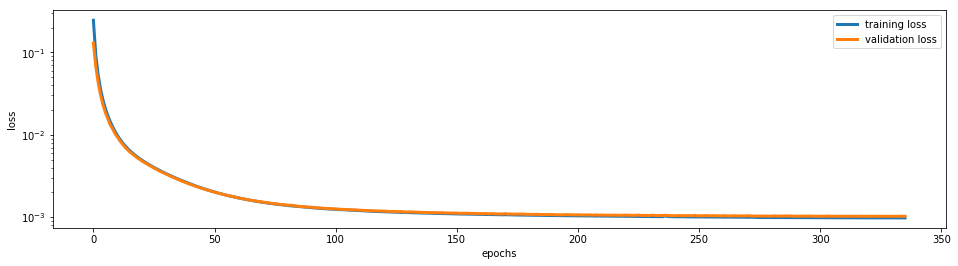

In [46]:
val_loss = history.history['val_loss']
loss = history.history['loss']

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(111)
ax1.plot(history.epoch[:],loss[:],val_loss[:],linewidth=3)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_yscale('log')
ax1.legend(['training loss','validation loss'])
plt.show()

In [ ]:
autoencoder.load_weights('cdae'+experiment_id+'.h5')
score = autoencoder.evaluate(X_attack.reshape(-1,X_attack.shape[1],1), X_attack_clean.reshape(-1,X_attack.shape[1],1))
print('testing score is',score)

# Computing model output
denoised_profiling = autoencoder.predict(X_profiling.reshape(-1,X_profiling.shape[1],1)).reshape(X_profiling.shape[0],-1)
denoised_attack = autoencoder.predict(X_attack.reshape(-1,X_attack.shape[1],1)).reshape(X_attack.shape[0],-1)

In [13]:
# Inverse mapminmax
denoised_profiling = min_max_scaler.inverse_transform(denoised_profiling)
denoised_attack = min_max_scaler.inverse_transform(denoised_attack)
X_profiling = min_max_scaler.inverse_transform(X_profiling)
X_attack = min_max_scaler.inverse_transform(X_attack)

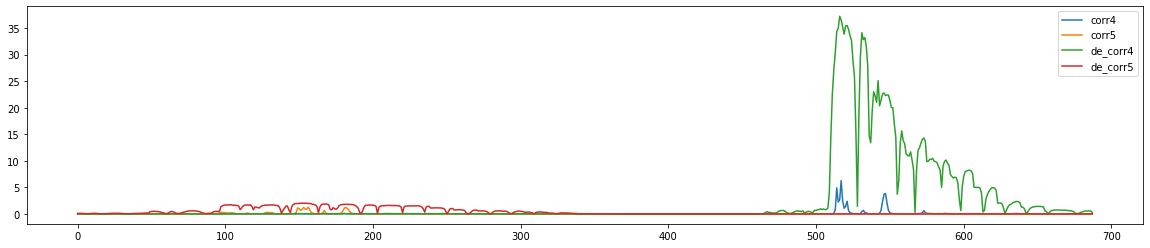

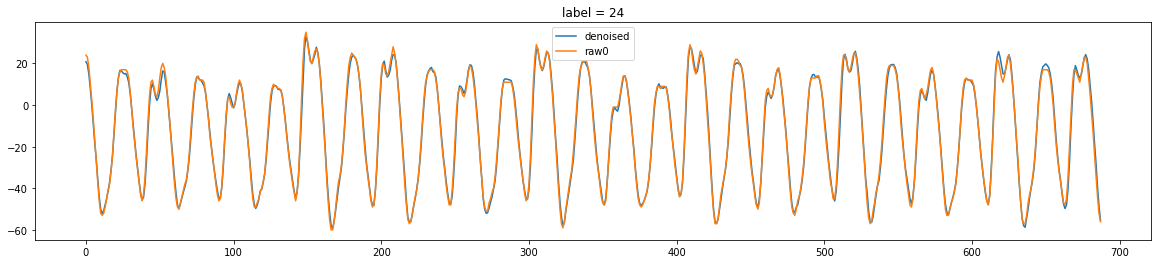

In [19]:
plt.figure(figsize=(20,4))
plt.plot(snr(X_profiling,v4.reshape(-1,1)),label='corr4')
plt.plot(snr(X_profiling,v5.reshape(-1,1)),label='corr5')
plt.plot(snr(denoised_profiling,v4.reshape(-1,1)),label='de_corr4')
plt.plot(snr(denoised_profiling,v5.reshape(-1,1)),label='de_corr5')
plt.legend()

i = np.where(Y_profiling==24)[0][4]
j = np.where(Y_profiling==24)[0][6]
plt.figure(figsize=(20,4))
plt.plot(denoised_profiling[i],label='denoised')
plt.plot(X_profiling[i],label='raw0')
plt.title('label = %d'%Y_profiling[i])
plt.legend()


## Load Preprocessed SSA Traces

In [70]:
in_file = h5py.File('./Traces/SSA_TRACE.h5', "r")
X_profiling_ssa = in_file['X_profiling_ssa1.5'][:]
X_attack_ssa = in_file['X_attack_ssa1.5'][:]
in_file.close()

## paper plot

In [30]:
def cal_HMweight(n):
    n = (n & 0x55555555) + ((n >> 1) & 0x55555555)
    n = (n & 0x33333333) + ((n >> 2) & 0x33333333)
    n = (n & 0x0F0F0F0F) + ((n >> 4) & 0x0F0F0F0F)
    n = (n & 0x00FF00FF) + ((n >> 8) & 0x00FF00FF)
    n = (n & 0x0000FFFF) + ((n >> 16) & 0x0000FFFF)
    return n

midval_id_v5 = v5_profiling
midval_hw_v5 = cal_HMweight(midval_id_v5)

tk_corr_v5 = corr(X_profiling, midval_id_v5)  ## Midvalue is in the first colume
poi_id_v5 = np.argsort(-np.abs(tk_corr_v5.T)).T
tk_corr_v5 = corr(X_profiling, midval_hw_v5)
poi_hw_v5 = np.argsort(-np.abs(tk_corr_v5.T)).T

trc_index_hw_v5 = []
for i in range(9):
    trc_index_hw_v5.append(np.where(midval_hw_v5==i)[0])
    
trc_index_id_v5 = []
for i in range(256):
    trc_index_id_v5.append(np.where(midval_id_v5==i)[0])
    
    
midval_id_v4 = v4_profiling
midval_hw_v4 = cal_HMweight(midval_id_v4)

tk_corr_v4 = corr(X_profiling, midval_id_v4)  ## Midvalue is in the first colume
poi_id_v4 = np.argsort(-np.abs(tk_corr_v4.T)).T
tk_corr_v4 = corr(X_profiling, midval_hw_v4)
poi_hw_v4 = np.argsort(-np.abs(tk_corr_v4.T)).T

trc_index_hw_v4 = []
for i in range(9):
    trc_index_hw_v4.append(np.where(midval_hw_v4==i)[0])
    
trc_index_id_v4 = []
for i in range(256):
    trc_index_id_v4.append(np.where(midval_id_v4==i)[0])

### KDE Plot (Original Traces)
This is the Kernel Density Estimation (KDE) of the point of interest, one is for masked Sbox output v and the other is for mask m.

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


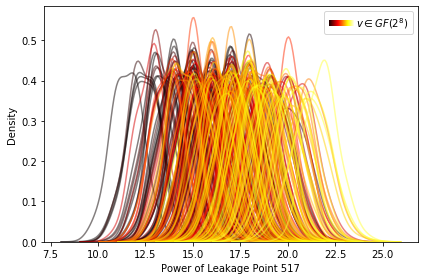

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


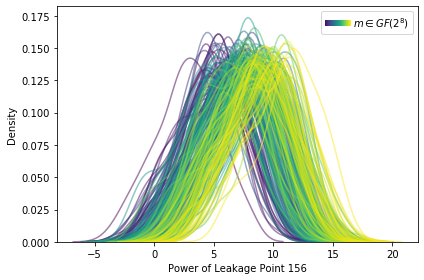

In [68]:
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import norm

custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(X_profiling[trc_index_id_v4[i],poi_id_v4[0]],kde_kws={"color": plt.cm.hot(i-50),'alpha':0.5,"bw":0.65},hist=False)
ax1.legend(custom_lines, [r'$v \in GF(2^8)$'],loc=1)
plt.xlabel('Power of Leakage Point '+str(np.argmax(np.abs(tk_corr_v4))))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.770, 0.895, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/ascad_hist_1.pdf')
plt.show()



custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(X_profiling[trc_index_id_v5[i],poi_id_v5[0]],kde_kws={"color": plt.cm.viridis(i),'alpha':0.5},hist=False)
ax1.legend(custom_lines, [r'$m \in GF(2^8)$'],loc=1)
plt.xlabel('Power of Leakage Point '+str(np.argmax(np.abs(tk_corr_v5))))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.760, 0.895, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/ascad_hist_2.pdf')
plt.show()





### KDE Plot (CDAE Preprocessed Traces)

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


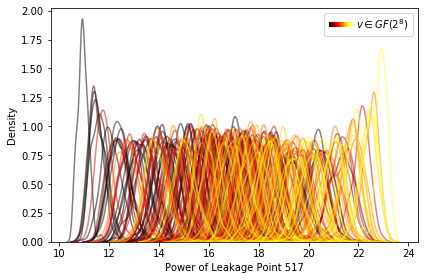

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


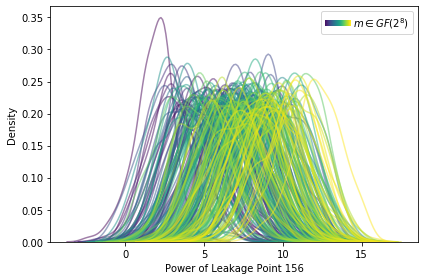

In [67]:
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import norm

custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(denoised_profiling[trc_index_id_v4[i],poi_id_v4[0]],kde_kws={"color": plt.cm.hot(i-50),'alpha':0.5},hist=False)
ax1.legend(custom_lines, [r'$v \in GF(2^8)$'],loc=1)
plt.xlabel('Power of Leakage Point '+str(np.argmax(np.abs(tk_corr_v4))))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.770, 0.89, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/ascad_hist_3.pdf')
plt.show()



custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(denoised_profiling[trc_index_id_v5[i],poi_id_v5[0]],kde_kws={"color": plt.cm.viridis(i),'alpha':0.5},hist=False)
ax1.legend(custom_lines, [r'$m \in GF(2^8)$'],loc=1)
plt.xlabel('Power of Leakage Point '+str(np.argmax(np.abs(tk_corr_v5))))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.760, 0.895, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/ascad_hist_4.pdf')
plt.show()





### Signal-Noise Ratio (SNR) for Original Traces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


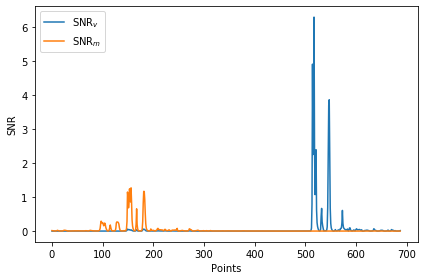

In [163]:
plt.plot(snr(X_profiling,v4_profiling),label=r'SNR$_v$')
plt.plot(snr(X_profiling,v5_profiling),label=r'SNR$_m$')
plt.legend(loc=2)
plt.xlabel('Points')
plt.ylabel('SNR')
plt.tight_layout()
    plt.savefig('./fig/ascad_snr_ori.eps')

### Signal-Noise Ratio (SNR) for CDAE Prepocessed Traces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


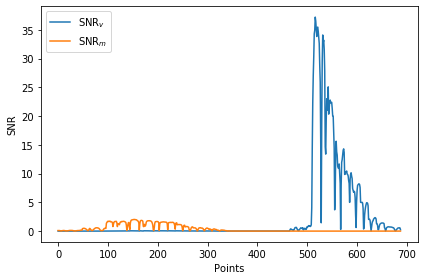

In [164]:
plt.plot(snr(denoised_profiling,v4_profiling),label=r'SNR$_v$')
plt.plot(snr(denoised_profiling,v5_profiling),label=r'SNR$_m$')
plt.legend(loc=2)
plt.xlabel('Points')
plt.ylabel('SNR')
plt.tight_layout()
plt.savefig('./fig/ascad_snr_cdae.eps')

### Pearson Correlation Coefficient (PCC) for Original Traces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


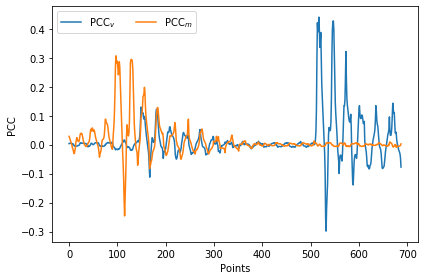

In [161]:
plt.plot(corr(X_profiling,v4_profiling),label=r'PCC$_v$')
plt.plot(corr(X_profiling,v5_profiling),label=r'PCC$_m$')
plt.legend(ncol=2,loc=2)
plt.xlabel('Points')
plt.ylabel('PCC')
plt.tight_layout()
plt.savefig('./fig/ascad_pcc_ori.eps')

### Pearson Correlation Coefficient (PCC) for CDAE Prepocessed Traces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


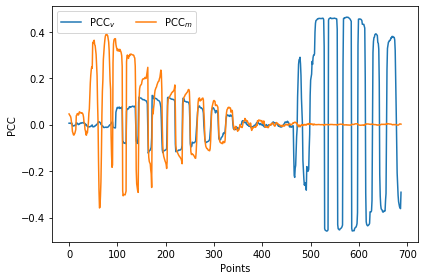

In [162]:
plt.plot(corr(denoised_profiling,v4_profiling),label=r'PCC$_v$')
plt.plot(corr(denoised_profiling,v5_profiling),label=r'PCC$_m$')
plt.legend(ncol=2,loc=2)
plt.xlabel('Points')
plt.ylabel('PCC')
plt.tight_layout()
plt.savefig('./fig/ascad_pcc_cdae.eps')

In [73]:
print('v4:masked sbox out')
print('pcc: ours,ssa,ori',np.abs(corr(denoised_profiling,v4_profiling)).max(),np.abs(corr(X_profiling_ssa,v4_profiling)).max(),np.abs(corr(X_profiling,v4_profiling)).max())
print('snr: ours,ssa,ori',np.abs(snr(denoised_profiling,v4_profiling)).max(),np.abs(snr(X_profiling_ssa,v4_profiling)).max(),np.abs(snr(X_profiling,v4_profiling)).max())


v4:masked sbox out
pcc: ours,ssa,ori 0.46289541166841436 0.3695557326168733 0.4406351549303367
snr: ours,ssa,ori 37.22675 1.5653657912076138 6.287096090743421


In [74]:
print('v5:mask')
print('pcc: ours,ssa,ori',np.abs(corr(denoised_profiling,v5_profiling)).max(),np.abs(corr(X_profiling_ssa,v5_profiling)).max(),np.abs(corr(X_profiling,v5_profiling)).max())
print('snr: ours,ssa,ori',np.abs(snr(denoised_profiling,v5_profiling)).max(),np.abs(snr(X_profiling_ssa,v5_profiling)).max(),np.abs(snr(X_profiling,v5_profiling)).max())


v5:mask
pcc: ours,ssa,ori 0.39022119335013755 0.25972636094284235 0.3068116945880985
snr: ours,ssa,ori 2.0315025 0.9388018496895277 1.2734825579067421


## 2nd order TA attack

In [ ]:
from PoiSelection import PoiSelection
from TemplateAttacks import *
from Evaluation import *

In [76]:
from ASCAD_evaluator import *
def check_ascad(predictions, ascad_database, num_traces=2000):
    check_file_exists(ascad_database)
    # Load profiling and attack data and metadata from the ASCAD database
    _, _, (Metadata_profiling, Metadata_attack) = load_ascad(ascad_database, load_metadata=True)
    # We test the rank over traces of the Attack dataset, with a step of 10 traces
    ranks = full_ranks(predictions, Metadata_attack, 0, num_traces, 10)
    # We plot the results
    x = [ranks[i][0] for i in range(0, ranks.shape[0])]
    y = [ranks[i][1] for i in range(0, ranks.shape[0])]
    return y

In [77]:
def gen_normalized_product_trace(X_train, X_test, y1, y2, poi_type = 'snr', poi_num = 20, poi_id_y1 =[], poi_id_y2 =[]):
    X_train_new = np.zeros((X_train.shape[0],poi_num**2))
    X_test_new = np.zeros((X_test.shape[0],poi_num**2))

    if poi_type == 'snr':
        tk_y1 = snr(X_train, y1)  
        tk_y2 = snr(X_train, y2)  
        poi_id_y1 = np.argsort(-np.abs(tk_y1))
        poi_id_y2 = np.argsort(-np.abs(tk_y2))
    elif poi_type == 'corr':
        tk_y1 = corr(X_train, y1)  
        tk_y2 = corr(X_train, y2)
        poi_id_y1 = np.argsort(-np.abs(tk_y1))
        poi_id_y2 = np.argsort(-np.abs(tk_y2))
    elif poi_type == 'custom':
        pass

    col = 0
    for i in poi_id_y1[:poi_num]:
        for j in poi_id_y2[:poi_num]:
            X_train_new[:,col] = (X_train[:,i]-np.mean(X_train[:,i]))/np.std(X_train[:,i])*(X_train[:,j]-np.mean(X_train[:,j]))/np.std(X_train[:,j])
            X_test_new[:,col] = (X_test[:,i]-np.mean(X_test[:,i]))/np.std(X_test[:,i])*(X_test[:,j]-np.mean(X_test[:,j]))/np.std(X_test[:,j])
            col += 1
    return X_train_new, X_test_new

def sepgen_normalized_product_trace(X_train, X_test, y1, y2, poi_type = 'snr', poi_num = 100, poi_id_y1 =[], poi_id_y2 =[]):
    X_train_new = np.zeros((X_train.shape[0],poi_num))
    X_test_new = np.zeros((X_test.shape[0],poi_num))

    if poi_type == 'snr':
        tk_y1 = snr(X_train, y1)  
        tk_y2 = snr(X_train, y2)  
        poi_id_y1 = np.argsort(-np.abs(tk_y1))
        poi_id_y2 = np.argsort(-np.abs(tk_y2))
    elif poi_type == 'corr':
        tk_y1 = corr(X_train, y1)  
        tk_y2 = corr(X_train, y2)
        poi_id_y1 = np.argsort(-np.abs(tk_y1))
        poi_id_y2 = np.argsort(-np.abs(tk_y2))
    elif poi_type == 'custom':
        pass

    col = 0
    for i in range(100):
        X_train_new[:,col] = (X_train[:,poi_id_y1[i]]-np.mean(X_train[:,poi_id_y1[i]]))/np.std(X_train[:,poi_id_y1[i]])*(X_train[:,poi_id_y2[i]]-np.mean(X_train[:,poi_id_y2[i]]))/np.std(X_train[:,poi_id_y2[i]])
        X_test_new[:,col] = (X_test[:,poi_id_y1[i]]-np.mean(X_test[:,poi_id_y1[i]]))/np.std(X_test[:,poi_id_y1[i]])*(X_test[:,poi_id_y2[i]]-np.mean(X_test[:,poi_id_y2[i]]))/np.std(X_test[:,poi_id_y2[i]])
        col += 1
    return X_train_new, X_test_new
    
    
tk_y1 = corr(X_profiling, v3)  
tk_y2 = corr(X_profiling, v2)  
poi_id_y1 = np.argsort(-np.abs(tk_y1))
poi_id_y2 = np.argsort(-np.abs(tk_y2))
# poi_id_y1 = []
# poi_id_y2 = []
    
poi_num = 30
poi_type = 'corr'

X_profiling_new,X_attack_new = gen_normalized_product_trace(X_profiling,X_attack, v3, v2, poi_type = poi_type, poi_num = poi_num, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
denoised_profiling_new,denoised_attack_new = gen_normalized_product_trace(denoised_profiling,denoised_attack, v3, v2, poi_type = poi_type, poi_num = poi_num, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
X_profiling_ssa_new, X_attack_ssa_new = gen_normalized_product_trace(X_profiling_ssa, X_attack_ssa, v3, v2, poi_type = poi_type, poi_num = poi_num, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)

### HOTA 

In [118]:


poi_id_y1 = []
poi_id_y2 = []
result_2o_cov = {'raw':[],'dae':[],'ssa':[]}

poi_idx = []
matrix_type = 'covariance'
start,end,step = 1000,10000,1000

tk_y1 = snr(denoised_profiling, v5)  
tk_y2 = snr(denoised_profiling, v4)  
# poi_id_y1 = np.argsort(-np.abs(tk_y1))
# poi_id_y2 = np.argsort(-np.abs(tk_y2))
poi_id_y1 = []
poi_id_y2 = []

for poi_num in [5,25,50]:   
    print('\nStage '+str(i)+', each part poi_num =',poi_num)
    # propare the concatenate data
    poi_type = 'corr'
    X_profiling_new,X_attack_new = gen_normalized_product_trace(X_profiling,X_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    denoised_profiling_new,denoised_attack_new = gen_normalized_product_trace(denoised_profiling,denoised_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    X_profiling_ssa_new, X_attack_ssa_new = gen_normalized_product_trace(X_profiling_ssa, X_attack_ssa, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    
    poi_type = 'corr'
    denoised_profiling_new,denoised_attack_new = PoiSelection(denoised_profiling_new, Y_profiling, denoised_attack_new, Y_attack,poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_new,X_attack_new = PoiSelection(X_profiling_new, Y_profiling,X_attack_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_ssa_new,X_attack_ssa_new = PoiSelection(X_profiling_ssa_new, Y_profiling,X_attack_ssa_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_new,Y_profiling)
    prob_new,y_pred = TA_clf.predict(X_attack_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_new,Y_profiling)
    prob_de_new,y_pred = TA_clf.predict(denoised_attack_new)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_new,Y_profiling)
    prob_ssa_new,y_pred = TA_clf.predict(X_attack_ssa_new)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_cov['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_cov['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_cov['ssa'].append(multi_ge3)

    
    


Stage 2, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 10000 traces to achieve 80% success rate
more than 10000 traces to achieve <1 bit guessing entropy

7000 traces to achieve 80% success rate
7000 traces to achieve <1 key rank

more than 10000 traces to achieve 80% success rate
more than 10000 traces to achieve <1 bit guessing entropy

Stage 2, each part poi_num = 25
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[################

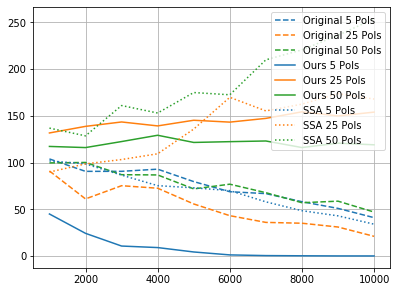

In [119]:
plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(True)
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_cov['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_cov['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_cov['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=1)

plt.show()




### HOTA reduced


Stage 2, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
800 traces to achieve 80% success rate
750 traces to achieve <1 key rank

400 traces to achieve 80% success rate
400 traces to achieve <1 key rank

more than 2000 traces to achieve 80% success rate
more than 2000 traces to achieve <1 bit guessing entropy

Stage 2, each part poi_num = 25
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[########################################################

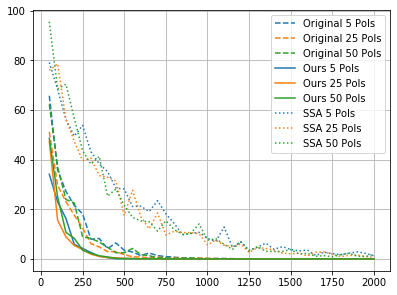

In [116]:


poi_id_y1 = []
poi_id_y2 = []
result_2o_reduced = {'raw':[],'dae':[],'ssa':[]}

poi_idx = []
matrix_type = 'reduced'
start,end,step = 50,2000,50

tk_y1 = snr(denoised_profiling, v5)  
tk_y2 = snr(denoised_profiling, v4)  
# poi_id_y1 = np.argsort(-np.abs(tk_y1))
# poi_id_y2 = np.argsort(-np.abs(tk_y2))
poi_id_y1 = []
poi_id_y2 = []

for poi_num in [5,25,50]:   
    print('\nStage '+str(i)+', each part poi_num =',poi_num)
    # propare the concatenate data
    poi_type = 'corr'
    X_profiling_new,X_attack_new = gen_normalized_product_trace(X_profiling,X_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    denoised_profiling_new,denoised_attack_new = gen_normalized_product_trace(denoised_profiling,denoised_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    X_profiling_ssa_new, X_attack_ssa_new = gen_normalized_product_trace(X_profiling_ssa, X_attack_ssa, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    
    poi_type = 'corr'
    denoised_profiling_new,denoised_attack_new = PoiSelection(denoised_profiling_new, Y_profiling, denoised_attack_new, Y_attack,poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_new,X_attack_new = PoiSelection(X_profiling_new, Y_profiling,X_attack_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_ssa_new,X_attack_ssa_new = PoiSelection(X_profiling_ssa_new, Y_profiling,X_attack_ssa_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_new,Y_profiling)
    prob_new,y_pred = TA_clf.predict(X_attack_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_new,Y_profiling)
    prob_de_new,y_pred = TA_clf.predict(denoised_attack_new)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_new,Y_profiling)
    prob_ssa_new,y_pred = TA_clf.predict(X_attack_ssa_new)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_reduced['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_reduced['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_reduced['ssa'].append(multi_ge3)

    
plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(True)
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_reduced['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_reduced['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_reduced['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=1)

plt.show()


 

### HOTA pooled


Stage 2, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
1400 traces to achieve 80% success rate
1200 traces to achieve <1 key rank

600 traces to achieve 80% success rate
550 traces to achieve <1 key rank

more than 2000 traces to achieve 80% success rate
more than 2000 traces to achieve <1 bit guessing entropy

Stage 2, each part poi_num = 25
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[######################################################

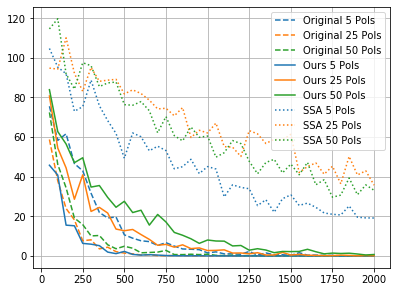

In [117]:
poi_id_y1 = []
poi_id_y2 = []
result_2o_pooled = {'raw':[],'dae':[],'ssa':[]}

poi_idx = []
matrix_type = 'pooled'
start,end,step = 50,2000,50

tk_y1 = snr(denoised_profiling, v5)  
tk_y2 = snr(denoised_profiling, v4)  
# poi_id_y1 = np.argsort(-np.abs(tk_y1))
# poi_id_y2 = np.argsort(-np.abs(tk_y2))
poi_id_y1 = []
poi_id_y2 = []

for poi_num in [5,25,50]:   
    print('\nStage '+str(i)+', each part poi_num =',poi_num)
    # propare the concatenate data
    poi_type = 'corr'
    X_profiling_new,X_attack_new = gen_normalized_product_trace(X_profiling,X_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    denoised_profiling_new,denoised_attack_new = gen_normalized_product_trace(denoised_profiling,denoised_attack, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    X_profiling_ssa_new, X_attack_ssa_new = gen_normalized_product_trace(X_profiling_ssa, X_attack_ssa, v5, v4, poi_type = poi_type, poi_num = 30, poi_id_y1=poi_id_y1, poi_id_y2=poi_id_y2)
    
    poi_type = 'corr'
    denoised_profiling_new,denoised_attack_new = PoiSelection(denoised_profiling_new, Y_profiling, denoised_attack_new, Y_attack,poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_new,X_attack_new = PoiSelection(X_profiling_new, Y_profiling,X_attack_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    X_profiling_ssa_new,X_attack_ssa_new = PoiSelection(X_profiling_ssa_new, Y_profiling,X_attack_ssa_new, Y_attack, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_new,Y_profiling)
    prob_new,y_pred = TA_clf.predict(X_attack_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_new,Y_profiling)
    prob_de_new,y_pred = TA_clf.predict(denoised_attack_new)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_new,Y_profiling)
    prob_ssa_new,y_pred = TA_clf.predict(X_attack_ssa_new)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_pooled['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_pooled['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_new,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_2o_pooled['ssa'].append(multi_ge3)

    
plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(True)
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_pooled['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_pooled['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,25,50]):
    plt.plot(np.arange(start,end+step,step),result_2o_pooled['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=1)

plt.show()


 

## PCA-TA
PCA with 5,10,15 principal components

### PCA-TA

In [101]:
from sklearn.decomposition import PCA

poi_id_y1 = []
poi_id_y2 = []
result_pca_cov = {'raw':[],'dae':[],'ssa':[]}

matrix_type = 'covariance'
start,end,step = 10,1000,10
    
for poi_num in [5,10,15]:    
    print('\nStage '+str(poi_num)+', each part poi_num =',poi_num)
    # propare the concatenate data
    pca=PCA(n_components=poi_num) 
    denoised_profiling_pca = pca.fit_transform(denoised_profiling)
    denoised_attack_pca = pca.transform(denoised_attack)
    
    pca=PCA(n_components=poi_num) 
    X_profiling_pca = pca.fit_transform(X_profiling)
    X_attack_pca = pca.transform(X_attack)

    pca=PCA(n_components=poi_num) 
    X_profiling_ssa_pca = pca.fit_transform(X_profiling_ssa)
    X_attack_ssa_pca = pca.transform(X_attack_ssa) 
    
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_pca,Y_profiling)
    prob_pca,y_pred = TA_clf.predict(X_attack_pca)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_pca,Y_profiling)
    prob_de_pca,y_pred = TA_clf.predict(denoised_attack_pca)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_pca,Y_profiling)
    prob_ssa_pca,y_pred = TA_clf.predict(X_attack_ssa_pca)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_cov['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_cov['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_cov['ssa'].append(multi_ge3)

    
    


Stage 5, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

160 traces to achieve 80% success rate
160 traces to achieve <1 key rank

more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

Stage 10, each part poi_num = 10
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[#####################

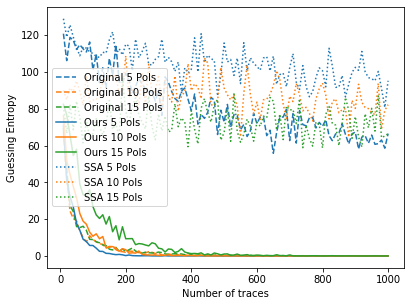

In [102]:

plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(False)
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_cov['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_cov['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_cov['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=0)
plt.xlabel('Number of traces')
plt.ylabel('Guessing Entropy')
# plt.savefig('./fig/ascad_attack2.png',bbox_inches = 'tight',dpi=800)
plt.show()


### PCA-TA reduced


Stage 5, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

Stage 10, each part poi_num = 10
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estim

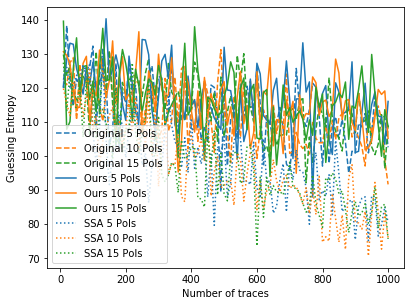

In [104]:
from sklearn.decomposition import PCA

poi_id_y1 = []
poi_id_y2 = []
result_pca_pool = {'raw':[],'dae':[],'ssa':[]}

matrix_type = 'reduced'
start,end,step = 10,1000,10
    
for poi_num in [5,10,15]:    
    print('\nStage '+str(poi_num)+', each part poi_num =',poi_num)
    # propare the concatenate data
    pca=PCA(n_components=poi_num) 
    denoised_profiling_pca = pca.fit_transform(denoised_profiling)
    denoised_attack_pca = pca.transform(denoised_attack)
    
    pca=PCA(n_components=poi_num) 
    X_profiling_pca = pca.fit_transform(X_profiling)
    X_attack_pca = pca.transform(X_attack)

    pca=PCA(n_components=poi_num) 
    X_profiling_ssa_pca = pca.fit_transform(X_profiling_ssa)
    X_attack_ssa_pca = pca.transform(X_attack_ssa) 
    
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_pca,Y_profiling)
    prob_pca,y_pred = TA_clf.predict(X_attack_pca)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_pca,Y_profiling)
    prob_de_pca,y_pred = TA_clf.predict(denoised_attack_pca)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_pca,Y_profiling)
    prob_ssa_pca,y_pred = TA_clf.predict(X_attack_ssa_pca)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_pool['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_pool['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_pool['ssa'].append(multi_ge3)


plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(False)
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_pool['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_pool['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_pool['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=0)
plt.xlabel('Number of traces')
plt.ylabel('Guessing Entropy')
# plt.savefig('./fig/ascad_attack2.png',bbox_inches = 'tight',dpi=800)
plt.show()
    

### PCA-TA pooled


Stage 5, each part poi_num = 5
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

more than 1000 traces to achieve 80% success rate
more than 1000 traces to achieve <1 bit guessing entropy

Stage 10, each part poi_num = 10
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estim

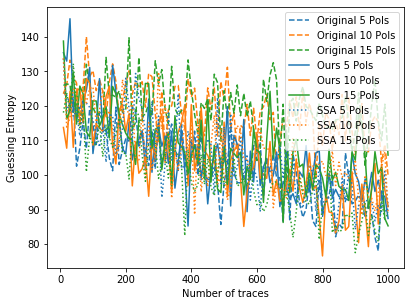

In [105]:
from sklearn.decomposition import PCA

poi_id_y1 = []
poi_id_y2 = []
result_pca_reduced = {'raw':[],'dae':[],'ssa':[]}

matrix_type = 'pooled'
start,end,step = 10,1000,10
    
for poi_num in [5,10,15]:    
    print('\nStage '+str(poi_num)+', each part poi_num =',poi_num)
    # propare the concatenate data
    pca=PCA(n_components=poi_num) 
    denoised_profiling_pca = pca.fit_transform(denoised_profiling)
    denoised_attack_pca = pca.transform(denoised_attack)
    
    pca=PCA(n_components=poi_num) 
    X_profiling_pca = pca.fit_transform(X_profiling)
    X_attack_pca = pca.transform(X_attack)

    pca=PCA(n_components=poi_num) 
    X_profiling_ssa_pca = pca.fit_transform(X_profiling_ssa)
    X_attack_ssa_pca = pca.transform(X_attack_ssa) 
    
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_pca,Y_profiling)
    prob_pca,y_pred = TA_clf.predict(X_attack_pca)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_profiling_pca,Y_profiling)
    prob_de_pca,y_pred = TA_clf.predict(denoised_attack_pca)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(X_profiling_ssa_pca,Y_profiling)
    prob_ssa_pca,y_pred = TA_clf.predict(X_attack_ssa_pca)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_reduced['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_reduced['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_pca,Y_attack),start,end,step,eval_time=100,log_sum=False)
    result_pca_reduced['ssa'].append(multi_ge3)


plt.figure(figsize=(6.4, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(False)
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_reduced['raw'][i],color = colors[i],linestyle = '--',label='Original '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_reduced['dae'][i],color = colors[i],linestyle = '-',label='Ours '+str(j)+' PoIs')
for i,j in zip(range(3),[5,10,15]):
    plt.plot(np.arange(start,end+step,step),result_pca_reduced['ssa'][i],color = colors[i],linestyle = ':',label='SSA '+str(j)+' PoIs')


plt.xscale('linear')
plt.legend(loc=0)
plt.xlabel('Number of traces')
plt.ylabel('Guessing Entropy')
# plt.savefig('./fig/ascad_attack2.png',bbox_inches = 'tight',dpi=800)
plt.show()
    